# PROJECT

### The problem

Let us consider the two-dimensional spatial domain  
$$
\Omega = (0,1)^2.
$$  

We want to solve the following **parametrized problem**:  
given  
$$
\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2,
$$  
find $u(\mu)$ such that
$$
- \Delta u(\mu) + \frac{\mu_0}{\mu_1} \left( e^{\mu_1 u(\mu)} - 1 \right) = g(x; \mu),
$$  
with **homogeneous Dirichlet boundary conditions** on $\partial\Omega$.

### Part 1

The source term is defined as:  
$$
g(x; \mu) = g_1(x) = 100 \sin(2\pi x_0) \cos(2\pi x_1), \quad \forall x = (x_0, x_1) \in \Omega.
$$


### Variational formulation

Let $\Omega = (0,1)^2$ and $V = H_0^1(\Omega)$.  
Given $\mu = (\mu_0, \mu_1) \in [0.1, 1]^2$,  
find $u(\mu) \in V$ such that
$$
\underbrace{\int_{\Omega} \nabla u(\mu) \cdot \nabla v \, dx}_{f_1}
+ \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u(\mu)} v \, dx}_{f_2}
- \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx}_{f_3}
- \underbrace{\int_{\Omega} g(x; \mu) v \, dx}_{f_4} = 0,
\quad \forall v \in V.
$$

### Legend

- $f_1$: diffusion term -> collegato alla stiffness  
- $f_2$: nonlinear reaction term  
- $f_3$: constant reaction term  
- $f_4$: source term


### Linearized problem: Newton step
NB: C'E' DIPENDENZA DA MU OVUNQUE

At each iteration $k$, given $u^{(k)} \in V$, find the increment $\delta u^{(k)} \in V$ such that:
$$
J_F(u^{(k)},\delta u^{(k)}) \, \delta u^{(k)} = -F(u^{(k)}),
$$.
In our case:
$$
\left( \int_{\Omega} \nabla \delta u^{(k)} \cdot \nabla v \, dx
+ {\mu_0} \int_{\Omega} e^{\mu_1 u^{(k)}} \delta u^{(k)} v \, dx\right) \delta u^{(k)}
= -F(u^{(k)}; v)
\quad \forall v \in V,
$$
where
$$
F(u^{(k)}; v) =
\int_{\Omega} \nabla u^{(k)} \cdot \nabla v \, dx
+ \frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u^{(k)}} v \, dx
- \frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx
- \int_{\Omega} g(x; \mu) v \, dx.
$$

Then update:
$$
u^{(k+1)} = u^{(k)} + \delta u^{(k)}.
$$
### Legend: RICORDA, ORA LA MIA VARIABILE E' DELTA_U_K, NON U_K
- $stiffness_a$: riferito a stiffness (primo a sinistra)
- $reaction_b$ : riferito alla reaction
- A DESTRA STESSI NOMI DI PRIMA( QUANDO ASSEMBLI FAI ATTENZIONE AI SEGNI) 
- $f_1$
- $f_2$
- $f_3$
- $f_4$



In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

 ### 1. POD

#### First, find High fidelity
Remember: since a(u,v) is non linear, we use the Newton emthod to solve it.

##### Define the quantities that we need to assemble the matrices

In [4]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
    #print("vecu max:", np.max(vecu))
    #print("mu_1 * vecu max:", np.max(mu_1 * vecu))
    return values_nl_b.ctypes.data

# f_4 (parte con la g)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


##### Define the Mesh size and the order of discretization

In [5]:
meshSize = 0.001
order = 1

##### Create the mesh and plot it

In [6]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

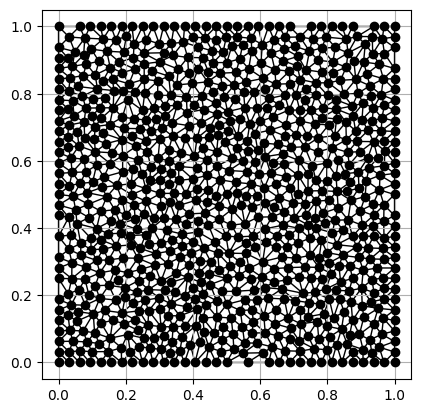

In [7]:
gedim.PlotMesh(mesh)

#### Create Discrete Space FEM and plot the mesh

In [8]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

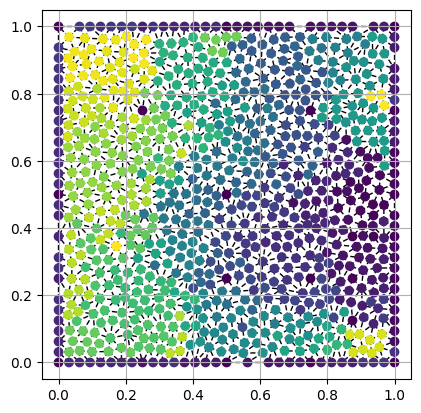

In [9]:
gedim.PlotDofs(mesh, dofs, strongs)

### Newton phase

#### Initial values and Hyperparameters

In [10]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [11]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [12]:
np.random.seed(42)  # Imposta il seed per la riproducibilità
snapshots_num = 100 # (M)
training_set = np.random.uniform(low=0.1, high=1, size=(snapshots_num, 2)) # training set

In [13]:
print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

snapshot_matrix = []

#tol = 1. - 1e-7  
tol = 1. - 1e-8 
N_max = 10

for mu in training_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    snapshot_matrix.append(np.copy(u_k))
    
snapshot_matrix = np.array(snapshot_matrix) 
print(snapshot_matrix.shape)

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.437, 0.956)
713      0.064    7.416327e-03   2      100      mu = (0.437, 0.956)
713      0.064    6.913777e-07   3      100      mu = (0.437, 0.956)
713      0.064    6.832626e-15   4      100      mu = (0.437, 0.956)
713      0.064    1.000000e+00   1      100      mu = (0.759, 0.639)
713      0.064    8.024056e-03   2      100      mu = (0.759, 0.639)
713      0.064    7.047266e-07   3      100      mu = (0.759, 0.639)
713      0.064    6.036808e-15   4      100      mu = (0.759, 0.639)
713      0.064    1.000000e+00   1      100      mu = (0.240, 0.240)
713      0.064    9.602267e-04   2      100      mu = (0.240, 0.240)
713      0.064    1.018505e-09   3      100      mu = (0.240, 0.240)
713      0.064    1.000000e+00   1      100      mu = (0.152, 0.880)
713      0.064    2.403785e-03   2      100      mu = (0.152, 0.880)
713      0.064    2.245932e-08   3

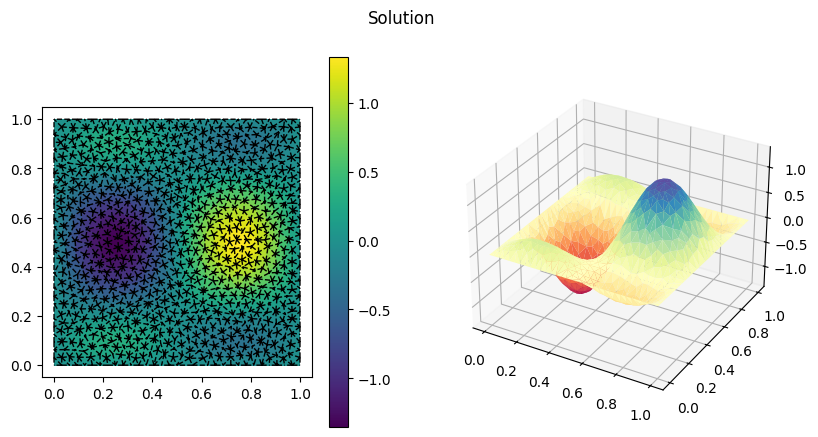

In [14]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [15]:
print("mesh.shape:", mesh.shape)              # Dovrebbe essere (2, N_nodes)
print("u_k.shape:", u_k.shape)
print("u_strong.shape:", u_strong.shape)


mesh.shape: (3, 830)
u_k.shape: (713,)
u_strong.shape: (117,)


### POD START

In [16]:
##### needed for the inner product #####

def Domain(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	return values.ctypes.data	

#### Scalar product for the covariance matrix

In [17]:
inner_product = stiffness ######## semi-norm (equivalent)

In [18]:
### covariance matrix

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 

###### shape?? ############

#### ALTERNATIVE:  VM, L, VMt = np.linalg.svd((C))

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy
#print(relative_retained_energy)


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N, '.')


The reduced dimension is 3 .


In [19]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
    eigenvector =  eigenvectors[n]
  
    # basis_component= (1/np.sqrt(snapshot_num))*np.transpose(snapshot_matrix)@eigenvector  (This is the one of the book!!)
  
    basis_component= np.transpose(snapshot_matrix)@eigenvector
    print("basis_component shape:", basis_component.shape)

    norm = np.sqrt(np.transpose(basis_component) @ inner_product @ basis_component) 
    basis_component/= norm
    basis_functions.append(np.copy(basis_component))

basis_functions = np.transpose(np.array(basis_functions))
print("basis shape:", basis_functions.shape)


basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis shape: (713, 3)


#### Functions used to assemble the reduced matrices and vectors

In [20]:
def assemble_reduced_matrix(basis, fom_matrix):
    return np.transpose(basis) @ (fom_matrix) @ basis

def assemble_reduced_vector(basis, fom_vector):
    return np.transpose(basis) @ (fom_vector)

#### Define the initial guess and strong vector at the FOM level

In [21]:
# initial guess u (viene rifatta nel for)
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberDOFs'], order='F')

#### Define the initial guess and strong vector at the ROM level

In [22]:
# our reduced initial guess (viene rifatta nel for)
reduced_u_k = np.zeros(N)
# value on the border (=0) bc homogenous dirichlet
reduced_u_strong = np.zeros(N)

#### Assemble the reduced versions for stiffness matrix and for the vectors for the term f3 and f4 
They are outside the loops so we can do it once and for all at the beginning.

In [23]:
 ##### STILL OFFLINE
reduced_stiff = assemble_reduced_matrix(basis_functions, stiffness)
reduced_f_3 = assemble_reduced_vector(basis_functions, forcingTerm_f_3)
reduced_f_4 = assemble_reduced_vector(basis_functions, forcingTerm_f_4)

#### Define a new test set for mu

In [24]:
# Choose new random seed bc we need a new test set
np.random.seed(23)

test_set = np.random.uniform(low=0.1, high=1, size=(100, 2)) # test set

#### Apply Newton to POD
The stopping criterion is based on the relative L2 norm of the èprojected POD solution at the FOM level.

In [38]:
import time

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))

sol_pod = []
times_pod = []

for mu in test_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    reduced_u_k = np.zeros(N)
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0 # = u_normL2

    time_pod = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        # Assemble these FOM level quantities in every iteration of the while loop
        
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)
        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)
        
        # Compute their reduced versions
        reduced_reaction = assemble_reduced_matrix(basis_functions, reaction)
        reduced_f_2 = assemble_reduced_vector(basis_functions, forcingTerm_f_2)
        reduced_der_f_1 = assemble_reduced_vector(basis_functions, forcingTerm_der_f_1)

        # define right and left hand sides fir the ROM level
        reduced_rhs = -reduced_der_f_1 - mu_0/mu_1 * reduced_f_2 + mu_0/mu_1 * reduced_f_3 + reduced_f_4
        reduced_lhs = reduced_stiff + mu_0 * reduced_reaction
        #print("LHS shape:", reduced_lhs.shape)
        #print("RHS shape:", reduced_rhs.shape)

        time_start = time.time()
        # solve linear system to find  reduced du
        reduced_du = np.linalg.solve(reduced_lhs, reduced_rhs)
        time_pod += time.time() - time_start
        # update reduced u_k
        reduced_u_k = reduced_u_k + reduced_du
        
        #project at the FOM LEVEL, we need u_k bc it is used to assemble the nonlinear terms
        du = basis_functions @ reduced_du
        u_k =  basis_functions @ reduced_u_k # quando invece faccio da ROM a FOM è col trasposto : b'vettore
        #print('uk is ', u_k)
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)"""
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
        
    sol_pod.append(np.copy(u_k))
    times_pod.append(time_pod)

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    9.475622e-03   2      100      mu = (0.566, 0.952)
713      0.064    1.341005e-06   3      100      mu = (0.566, 0.952)
713      0.064    7.259863e-13   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    4.503146e-03   2      100      mu = (0.789, 0.354)
713      0.064    9.770703e-08   3      100      mu = (0.789, 0.354)
713      0.064    0.000000e+00   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    3.707205e-03   2      100      mu = (0.299, 0.718)
713      0.064    6.786867e-08   3      100      mu = (0.299, 0.718)
713      0.064    1.435800e-12   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.906487e-03   2

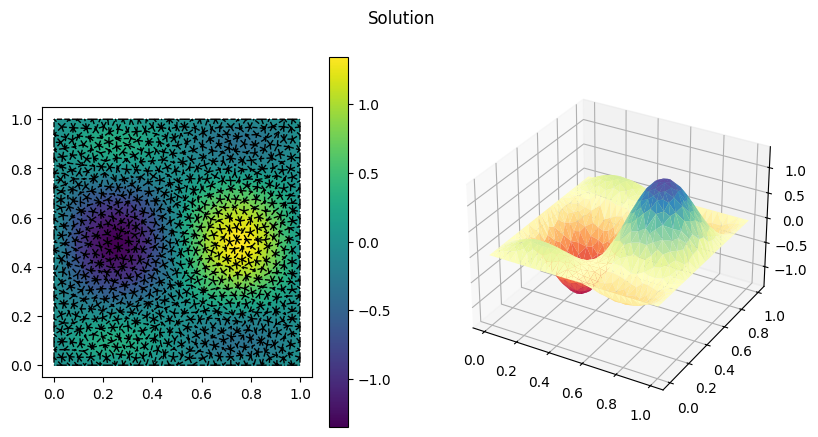

In [39]:
# Plot on the last mu of test_set
gedim.PlotSolution(mesh, dofs, strongs, u_k, np.zeros(problemData['NumberStrongs']))
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

#### Compute the HF solution on the last mu of test_set

In [40]:
#usiamo ultimo mu
mu = test_set[-1]
mu 

array([0.84508049, 0.3486542 ])

In [41]:

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)
u_normL2 = 1
u_normH1 = 1
num_iteration = 1
residual_norm = 10
solution_norm = 1.0
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

mu_0 = mu[0]
mu_1 = mu[1]
    
while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

    forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
    forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

    # define right and left hand sides
    rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
    lhs = stiffness + mu_0 * reaction
    # solve linear system to find du
    du = gedim.LUSolver(lhs, \
            rhs, \
            lib)
    #update u_k
    u_k = u_k + du
    
    du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
    u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)

    u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
    solution_norm =  u_normL2
    residual_norm =  du_normL2
    #print(residual_norm)
    """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
    
    print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
        problemData['NumberDOFs'],
        problemData['H'],
        residual_norm / u_normL2,
        num_iteration,
        max_iterations,
        mu_0,
        mu_1
    ))

    num_iteration += 1


DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.845, 0.349)
713      0.064    4.730435e-03   2      100      mu = (0.845, 0.349)
713      0.064    1.256451e-07   3      100      mu = (0.845, 0.349)
713      0.064    1.924925e-16   4      100      mu = (0.845, 0.349)


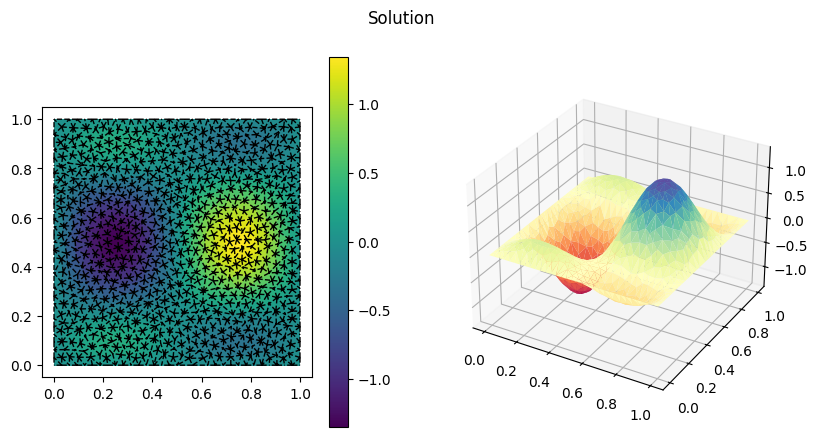

In [42]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

#### Compute the error of the POD solution wrt the HF solution

In [43]:
error_function = u_k - basis_functions@reduced_u_k
error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
absolute_error = np.sqrt(abs(error_norm_squared_component))
print(f'The absolute error of the POD solution on mu: {mu} wrt the HF solution is {absolute_error}.')

The absolute error of the POD solution on mu: [0.84508049 0.3486542 ] wrt the HF solution is 0.00029145977014706465.


#### BISOGENREBBE FARLO PER OGNI MU DEL TEST SET PER FARE POI MEDIA E SPEEDUP

In [44]:
# Troviamo le soluzioni high fidelity 

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)


sol_hf = []
times_hf = []

for mu in test_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0

    time_hf = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction

        time_start = time.time()
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        time_hf += time.time() - time_start
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    sol_hf.append(np.copy(u_k))
    times_hf.append(time_hf)

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    9.453471e-03   2      100      mu = (0.566, 0.952)
713      0.064    1.422986e-06   3      100      mu = (0.566, 0.952)
713      0.064    3.728250e-14   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    4.503949e-03   2      100      mu = (0.789, 0.354)
713      0.064    1.086983e-07   3      100      mu = (0.789, 0.354)
713      0.064    1.015308e-16   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    3.710673e-03   2      100      mu = (0.299, 0.718)
713      0.064    7.370379e-08   3      100      mu = (0.299, 0.718)
713      0.064    7.913749e-17   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.911868e-03   2

In [45]:
abs_err=[]
rel_err=[]
speed_up=[]

for i in range(len(sol_hf)):
    error_function = sol_hf[i] - sol_pod[i]
    error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(sol_hf[i]) @ inner_product @ sol_hf[i]
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)

    speed_up.append(times_hf[i]/times_pod[i])

In [46]:
print("Average relative error = ", np.mean(rel_err))
print("Average absolute error = ", np.mean(abs_err))
print("Average speed-up = ", np.mean(speed_up))

Average relative error =  4.389872064127869e-05
Average absolute error =  0.0002010935556857327
Average speed-up =  81.11051159441774
